In [14]:
from thermo.analysis.IO import create_group_by_day_plot, create_standard_plot, get_dataframe, get_plotting_dataframe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mat

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


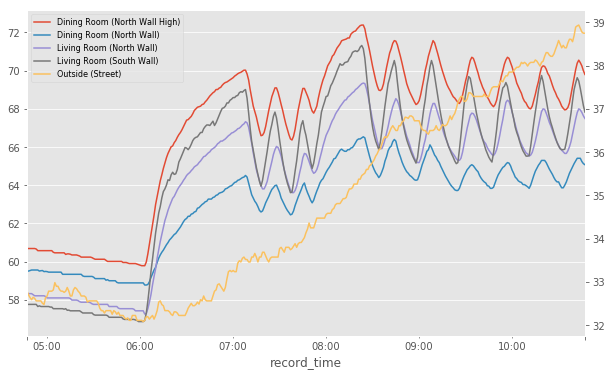

In [15]:
create_standard_plot(6);

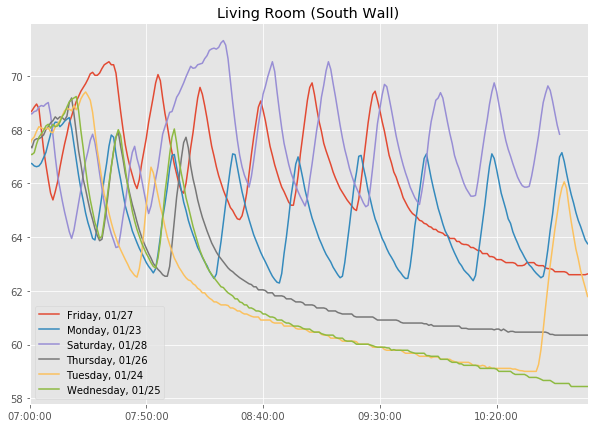

In [16]:
create_group_by_day_plot('Living Room (South Wall)', lookback=120+13, filter_hours=3, figsize=(10,7));

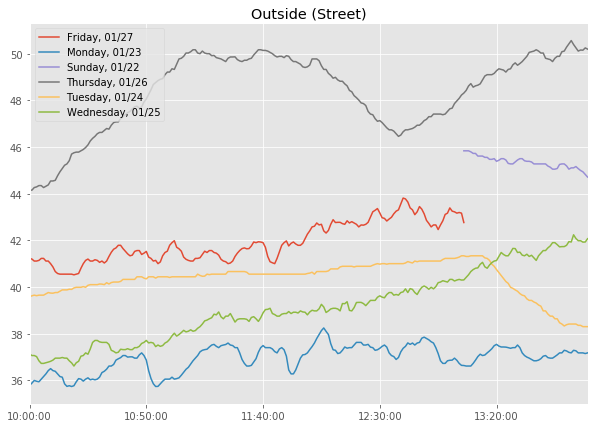

In [9]:
create_group_by_day_plot('Outside (Street)', filter_hours=3, figsize=(10,7));

In [51]:
df = get_dataframe(999)

In [45]:
df2 = df.resample('600S').median()

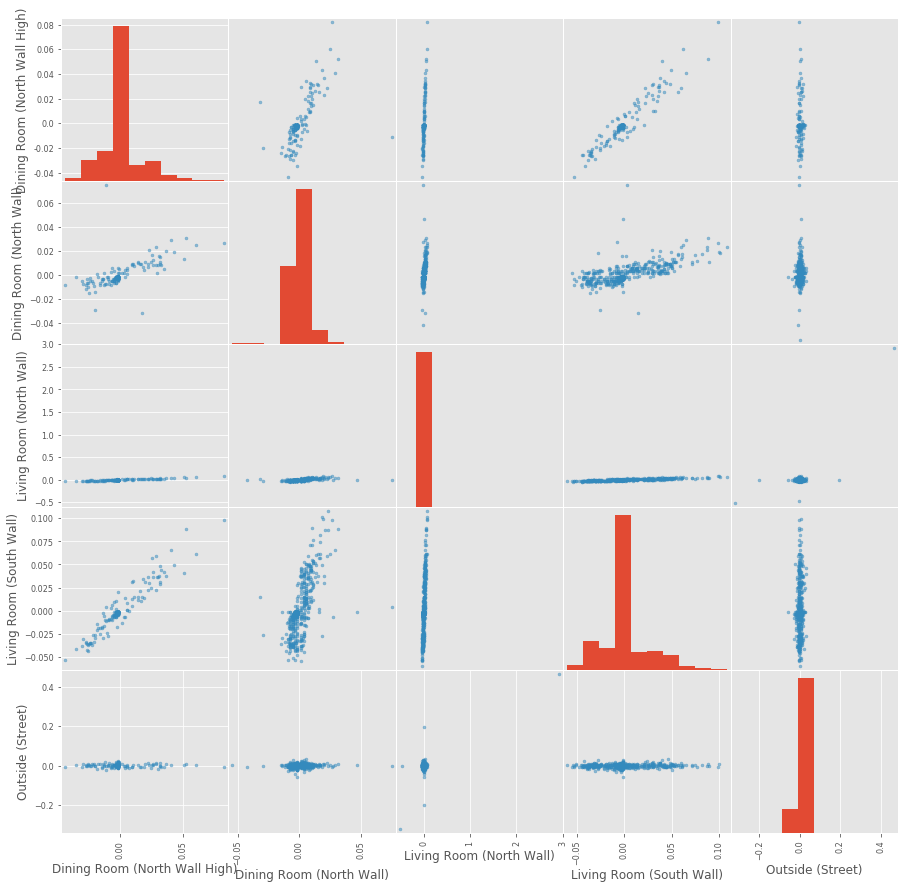

In [46]:
pd.tools.plotting.scatter_matrix(df2.pct_change().replace(0, np.nan), figsize=(15,15));

In [150]:
df2 = df.resample('300S').ohlc()

In [151]:
temp = df2['Dining Room (North Wall High)'].replace(0, np.nan).dropna()[-100:]

In [152]:
ohlc = []
for ser in temp.iteritems():
    ohlc.append(ser[1])

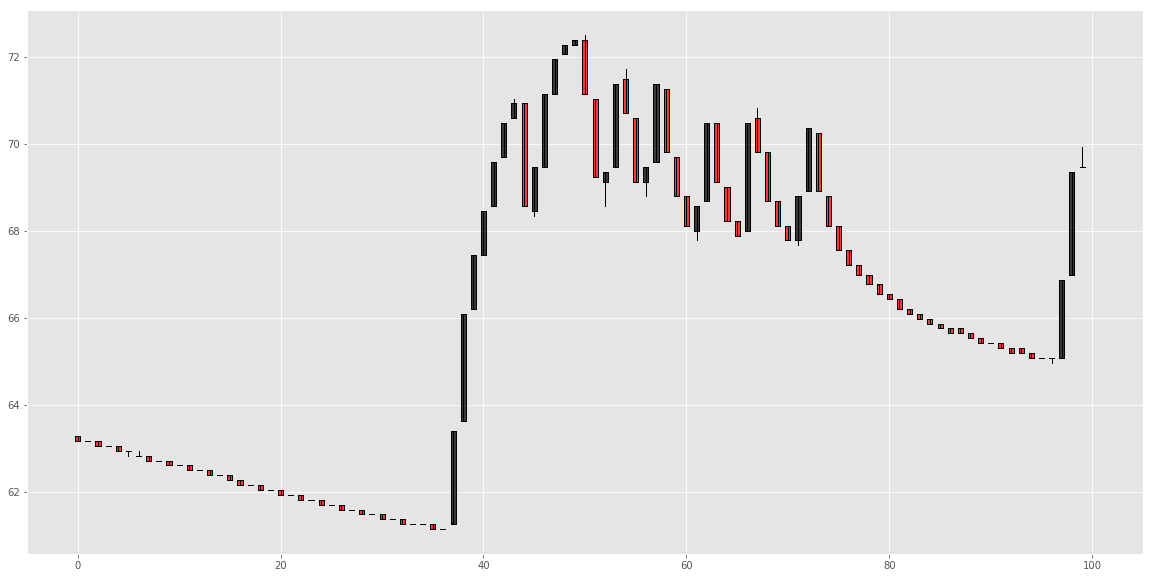

In [153]:
plt.figure(figsize=(20,10))
ax = plt.gca()
mat.finance.candlestick2_ohlc(ax, ohlc[0], ohlc[1], ohlc[2], ohlc[3], width=.5);

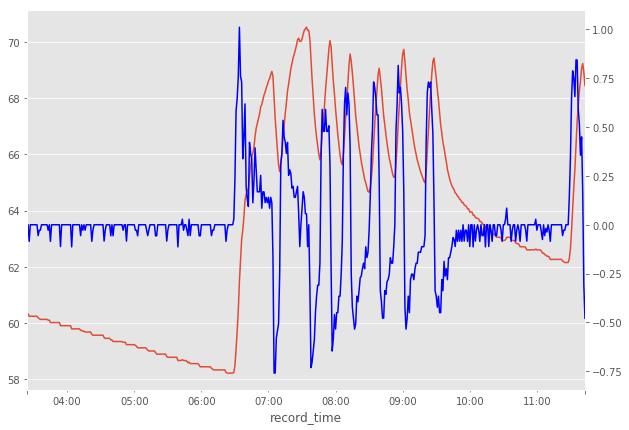

In [182]:
ax = df['Living Room (South Wall)'].resample('60S').mean().dropna()[-500:].plot(figsize=(10,7))
ax2 = df['Living Room (South Wall)'].resample('60S').mean().dropna()[-500:].diff().plot(ax=ax.twinx(), c = 'blue')
ax2.yaxis.grid(False)

In [183]:
d1 = df['Living Room (South Wall)'].resample('60S').mean().dropna()[-500:].diff()

In [341]:
df_sample = df['Living Room (South Wall)'].resample('60S').mean().dropna()[-500:]

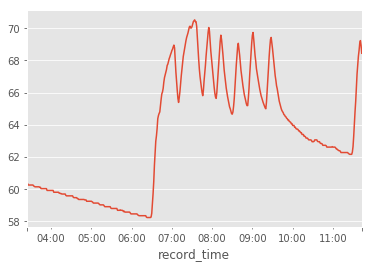

In [342]:
df_sample.plot()

# Trying to use logic to get widths

Doesn't really work, fourier may be better

In [284]:
def find_state_change(x, peak=True):
    going_up = None
    peak, trough = None, None
    
    for i in range(len(x)):
        j = i - len(x)
        
        if peak and peak is not None:
            return peak
        
        if trough and trough is not None:
            return trough
        
        if x[j] < x[-1]:
            if going_up == True and peak is None:
                trough = j
            going_up = False
            continue
        
        if x[j] > x[-1]:
            if going_up == False and trough is None:
                peak = j
            going_up = True
            continue
            
    return peak or np.nan
            

# Fourier transfor to fit oscilations?

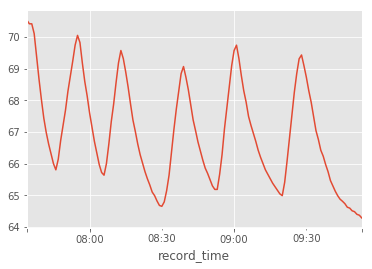

In [310]:
fft_sample = df_sample[250:390]
fft_sample.plot()

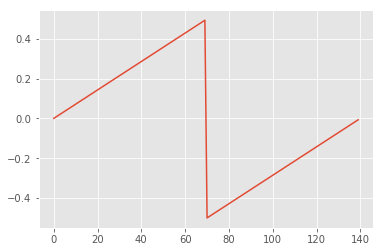

In [312]:
sp = np.fft.fft(fft_sample.values)
freq = np.fft.fftfreq(fft_sample.values.shape[-1])
plt.plot(freq)

# RDP Algo

This works pretty well, but you need a good idea of where the cycle starts and ends

In [313]:
from math import sqrt

def distance(a, b):
    return  sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

def point_line_distance(point, start, end):
    if (start == end):
        return distance(point, start)
    else:
        n = abs(
            (end[0] - start[0]) * (start[1] - point[1]) - (start[0] - point[0]) * (end[1] - start[1])
        )
        d = sqrt(
            (end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2
        )
        return n / d

def rdp(points, epsilon):
    """
    Reduces a series of points to a simplified version that loses detail, but
    maintains the general shape of the series.
    """
    dmax = 0.0
    index = 0
    for i in range(1, len(points) - 1):
        d = point_line_distance(points[i], points[0], points[-1])
        if d > dmax:
            index = i
            dmax = d
    if dmax >= epsilon:
        results = rdp(points[:index+1], epsilon)[:-1] + rdp(points[index:], epsilon)
    else:
        results = [points[0], points[-1]]
    return results

In [435]:
df_sample = df['Living Room (South Wall)'].resample('60S').mean().dropna()
rdp_list = [ (i,v) for i, v in zip(df_sample.reset_index().index.values, df_sample.values) ]
index, values = zip(*rdp(rdp_list, 2.0))

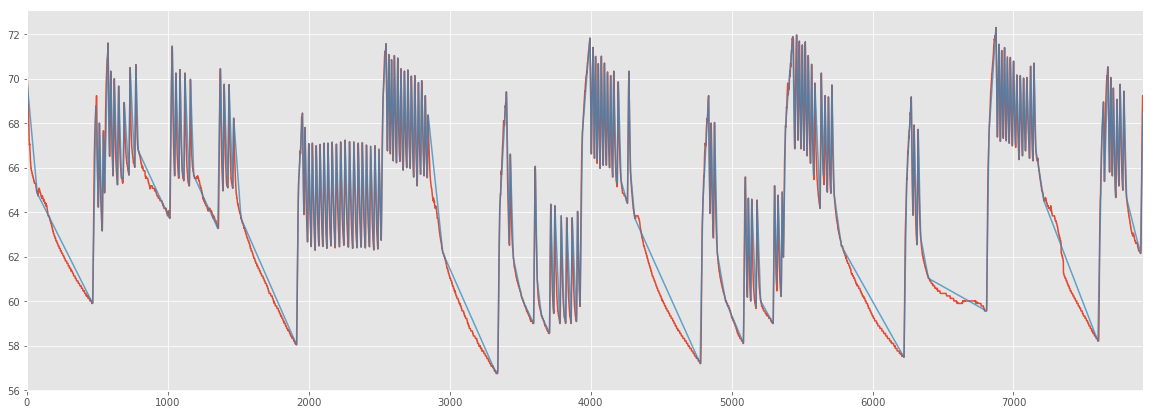

In [436]:
plt.figure(figsize=(20,7))
ax = plt.gca()
df_sample.reset_index(drop=True).plot(ax=ax)
ax.plot(index, values,alpha=.75)

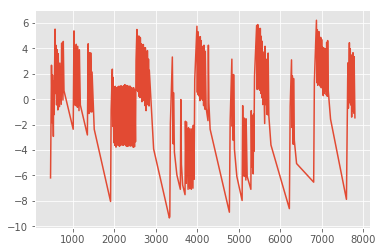

In [437]:
adjusted = values[2:-2]-np.mean(values[2:-2])
adjusted_index = index[2:-2]
plt.plot(adjusted_index, adjusted)

In [439]:
temp = pd.DataFrame(
    {
        'distance': adjusted_index,
        'value': adjusted
    }
)

temp['distance'][temp['value']<0].diff().median()

28.0

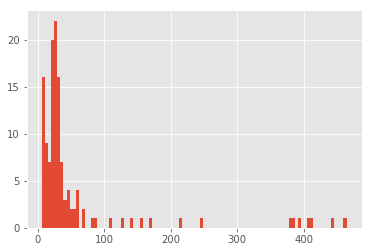

In [442]:
temp['distance'][temp['value']<0].diff().hist(bins=100);